In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

In [4]:

# Load dataset
df = pd.read_csv('diabetes2.csv')  # Update path to your file

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
print("\nClass Distribution:")
print(df['Outcome'].value_counts())


Class Distribution:
0    500
1    268
Name: Outcome, dtype: int64


In [7]:
# Handle zeros in medical features
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in zero_features:
    df[col] = df[col].replace(0, np.nan)
    df[col] = df[col].fillna(df[col].mean())

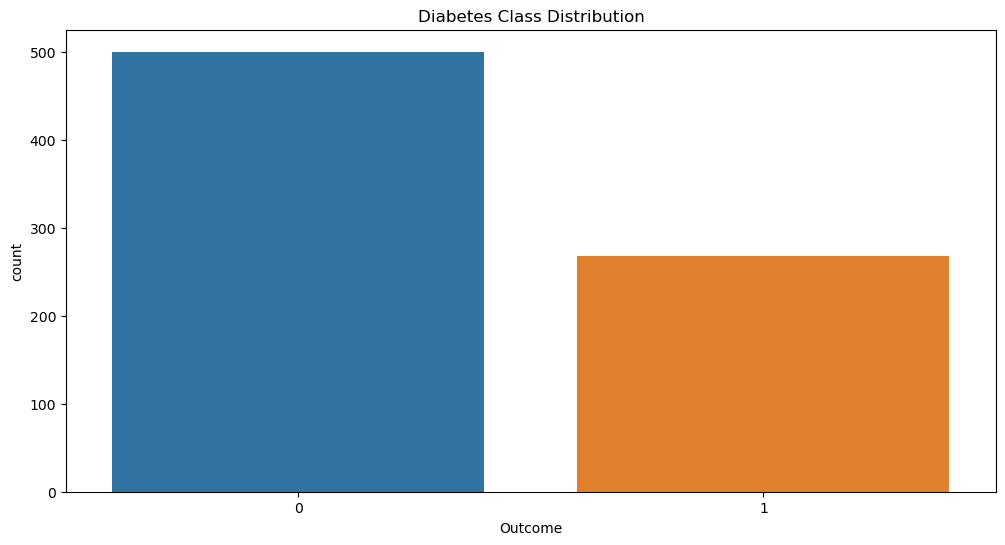

In [8]:


# Visualizations
plt.figure(figsize=(12,6))
sns.countplot(x='Outcome', data=df)
plt.title('Diabetes Class Distribution')
plt.show()

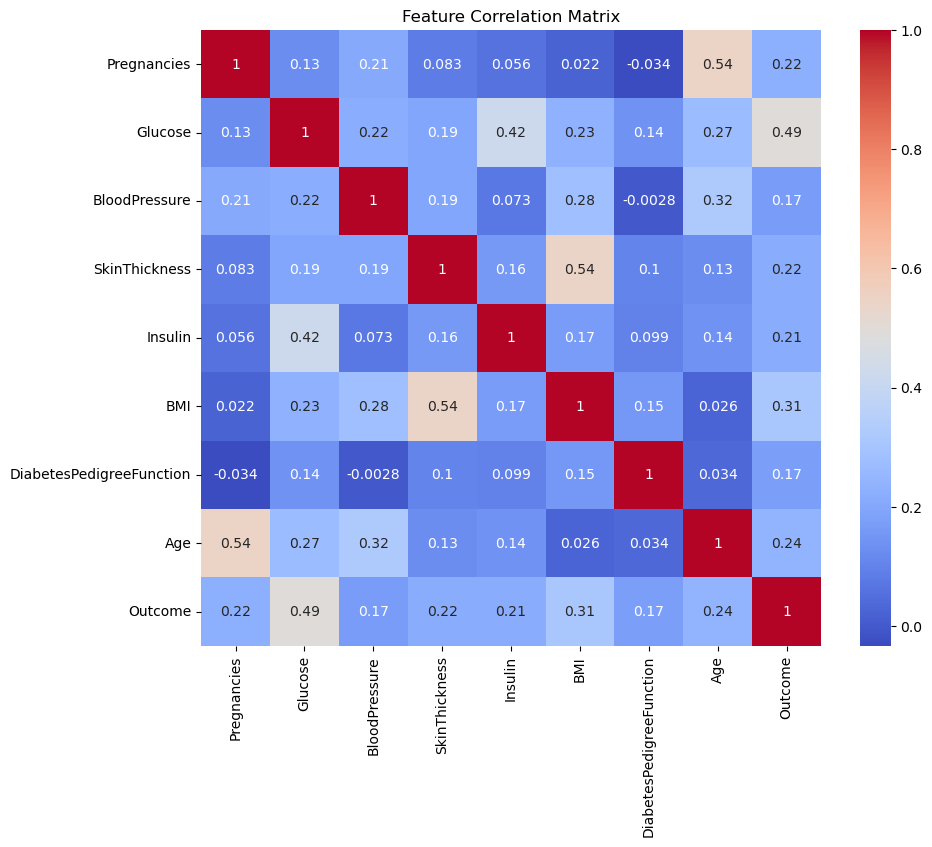

In [9]:

plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


In [10]:

# Preprocessing
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [11]:

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [12]:

# Handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Build neural network
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', 
                       'Precision',
                       'Recall',
                       'AUC'])


In [21]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs=100, 
                    batch_size=32,
                    class_weight=class_weights,
                    callbacks=[early_stop],
                    verbose=1)

# Evaluate model
print("\nModel Evaluation:")
loss, accuracy, precision, recall, auc_keras = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test AUC: {auc_keras:.2f}")

# Generate predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

Epoch 1/100
20/20 [==============================] - 0s 7ms/step - loss: 0.4658 - accuracy: 0.7622 - precision: 0.6314 - recall: 0.7559 - auc: 0.8580 - val_loss: 0.5246 - val_accuracy: 0.7208 - val_precision: 0.5789 - val_recall: 0.8000 - val_auc: 0.8248
Epoch 2/100
20/20 [==============================] - 0s 2ms/step - loss: 0.4643 - accuracy: 0.7638 - precision: 0.6328 - recall: 0.7606 - auc: 0.8588 - val_loss: 0.5276 - val_accuracy: 0.7208 - val_precision: 0.5789 - val_recall: 0.8000 - val_auc: 0.8242
Epoch 3/100
20/20 [==============================] - 0s 2ms/step - loss: 0.4626 - accuracy: 0.7687 - precision: 0.6360 - recall: 0.7793 - auc: 0.8592 - val_loss: 0.5295 - val_accuracy: 0.7208 - val_precision: 0.5789 - val_recall: 0.8000 - val_auc: 0.8235
Epoch 4/100
20/20 [==============================] - 0s 2ms/step - loss: 0.4608 - accuracy: 0.7655 - precision: 0.6332 - recall: 0.7700 - auc: 0.8606 - val_loss: 0.5296 - val_accuracy: 0.7208 - val_precision: 0.5789 - val_recall: 0.800

In [20]:

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))




Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.68      0.76        99
           1       0.58      0.80      0.67        55

    accuracy                           0.72       154
   macro avg       0.72      0.74      0.71       154
weighted avg       0.76      0.72      0.73       154



1. Key Metrics Explained
Precision: "When the model predicts diabetes, how often is it correct?"

Recall: "Out of all actual diabetic patients, how many did the model find?"

F1-Score: A balanced average of precision and recall (higher = better).

Support: Number of patients in each category.

2. For Non-Diabetic Patients (Class 0)
Precision = 0.86 (86%)

When the model predicts "no diabetes," it’s correct 86% of the time.

Example: If it predicts 100 people are non-diabetic, 86 are truly non-diabetic.

Recall = 0.68 (68%)

It detects 68% of all true non-diabetic patients.

Example: If 100 people are truly non-diabetic, the model misses 32 of them.

F1-Score = 0.76

A balanced score (good but not perfect).

3. For Diabetic Patients (Class 1)
Precision = 0.58 (58%)

When the model predicts "diabetes," it’s correct 58% of the time.

Example: If it predicts 100 people have diabetes, 58 truly do (42 are false alarms).

Recall = 0.80 (80%)

It detects 80% of all true diabetic patients.

Example: If 100 people truly have diabetes, the model misses 20.

F1-Score = 0.67

Lower than non-diabetic predictions (room for improvement).

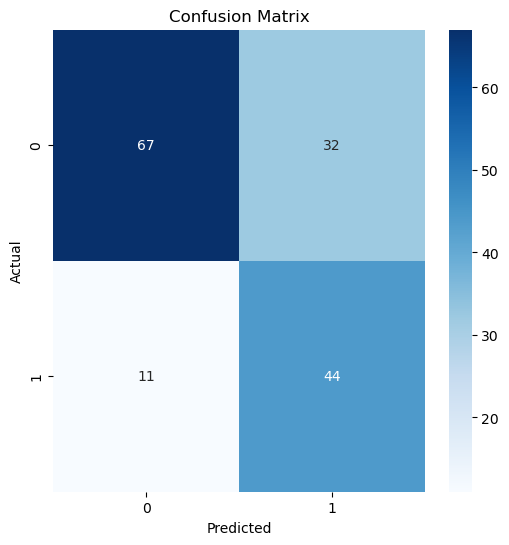

In [15]:
# Confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [22]:

# And later, compute ROC AUC using sklearn's auc:
from sklearn.metrics import auc  # Ensure this import exists
fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test))
roc_auc = auc(fpr, tpr)  # Now this uses the correct function

5/5 [==============================] - 0s 2ms/step


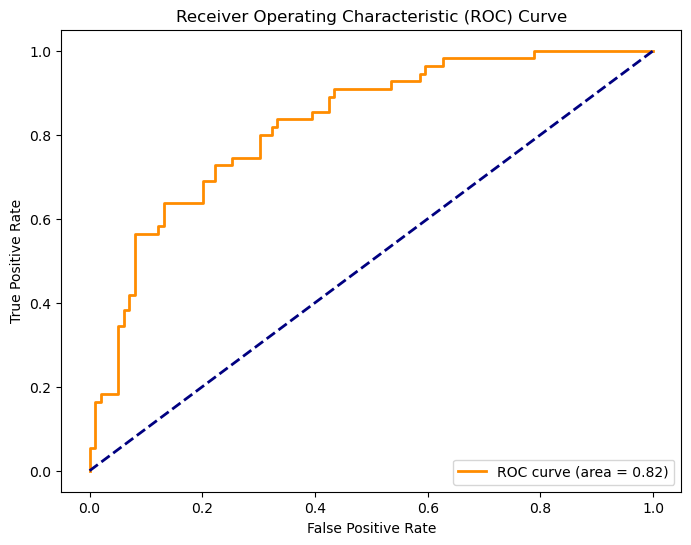

In [23]:

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()